In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

## Regression Example

In [2]:
np.random.seed(42)
n_samples = 100_000
x1 = np.random.uniform(0, 4, n_samples)
x2 = np.random.uniform(4, 8, n_samples)
y = ( x1 - 2 ) ** 2 + np.cos( 3 * x2 ) + np.random.normal(0, 1, n_samples) + 10

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [3]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 1.5, 2, 2.5, 3, 3.5],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [4.5, 5, 5.5, 6, 6.5, 7, 7.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist())

In [4]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
x2_bins, x2_labels = get_bins_and_labels(cutoffs=np.arange(4.2, 8, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_bins, labels=x2_labels )

In [5]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),}

In [6]:
from quantbullet.linear_product_model import LinearProductRegressorBCD

lpm_ols = LinearProductRegressorBCD()

In [7]:
lpm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, Loss: 1.0121
Iteration 2/10, Loss: 1.0122
Iteration 3/10, Loss: 1.0122
Iteration 4/10, Loss: 1.0122
Iteration 5/10, Loss: 1.0122
Iteration 6/10, Loss: 1.0122
Early stopping at iteration 6 with Loss: 1.0122


In [8]:
df['model_predict'] = lpm_ols.predict(train_df)

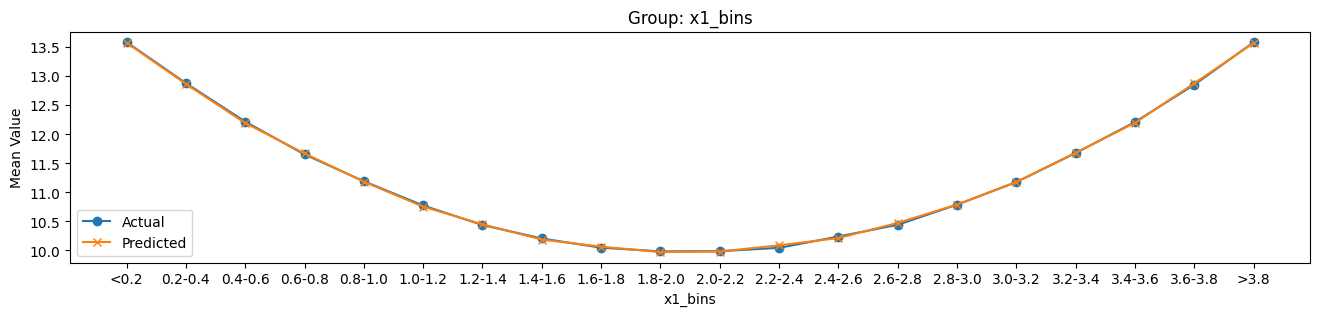

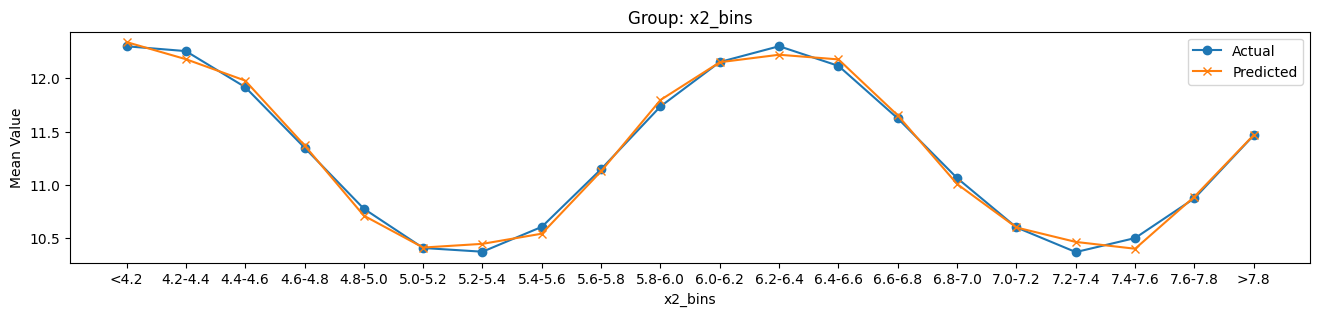

In [9]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classifier: SciPy Optimizer

In [10]:
np.random.seed(15)
probs = 1 / (1 + np.exp(-(df['y'] - 15)))
df['binary_y'] = np.random.binomial(1, probs)
df['binary_y'].mean()

np.float64(0.06902)

In [11]:
from quantbullet.linear_product_model import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-8, gtol=1e-8, eps=1e-3)

In [12]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups )

Using initial params: {'x1': array([0.00640331, 0.00300155, 0.005802  , 0.00860204, 0.01140604,
       0.01420706, 0.01700631, 0.01980698, 0.02260789]), 'x2': array([0.00088426, 0.00395184, 0.00433883, 0.00472603, 0.00511296,
       0.00549982, 0.00588657, 0.00627336, 0.00665981])}
Iter 1: 24906.30856086502
Iter 2: 24230.12916745928
Iter 3: 23186.617543117663
Iter 4: 22910.415620526037
Iter 5: 22816.884765077986
Iter 6: 22788.898302750727
Iter 7: 22713.723101373107
Iter 8: 22638.97506597355
Iter 9: 22578.22553378107
Iter 10: 22455.094544857748
Iter 11: 22301.715662182047
Iter 12: 22124.587060315185
Iter 13: 22110.982916386733
Iter 14: 22095.599411254563
Iter 15: 22082.137109648593
Iter 16: 22076.170966807058
Iter 17: 22074.65949616373
Iter 18: 22074.427808928038
Iter 19: 22074.161592439297
Iter 20: 22073.608388722856
Iter 21: 22072.046973631754
Iter 22: 22068.406875931807
Iter 23: 22060.29723717622
Iter 24: 22046.707474890274
Iter 25: 22037.345227936778
Iter 26: 22018.769949876514
Iter

In [13]:
lpc_scipy.coef_

array([-5.48996309, -1.5602222 , -0.38866469, -0.09633554, -0.04667165,
        0.0406545 ,  0.11299568,  0.40654905,  1.5291551 ,  1.16508417,
       -0.27866651, -0.48968033,  0.01052709,  0.53136897,  0.1755174 ,
       -0.68311231, -0.09422474,  0.49708221])

In [14]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict(train_df)

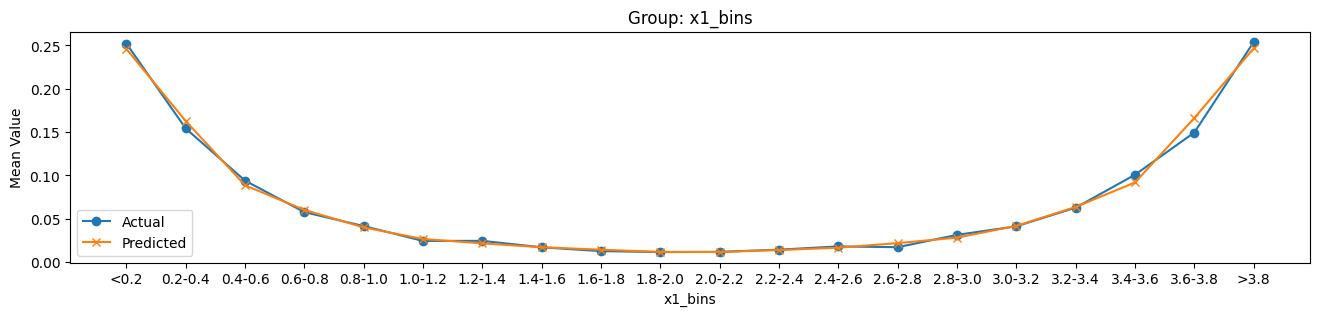

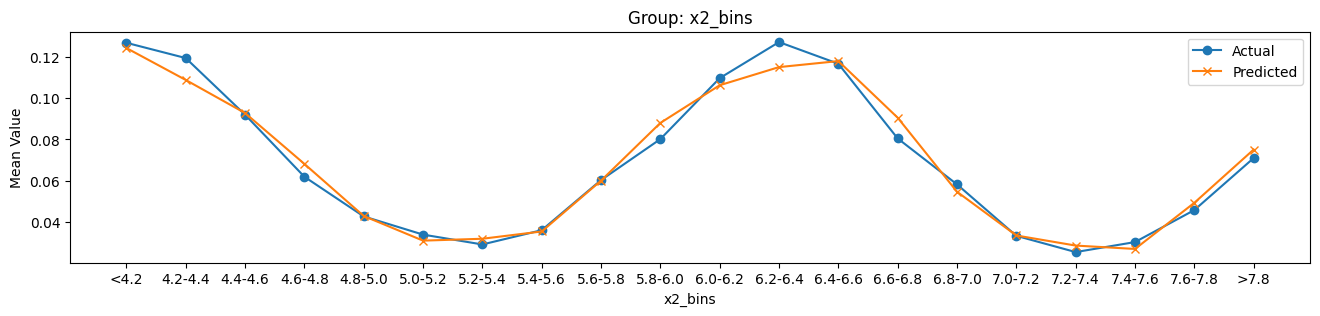

In [15]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classifier: Block Coordinate Descent

In [16]:
from quantbullet.linear_product_model import LinearProductClassifierBCD

In [17]:
lpc_bcd = LinearProductClassifierBCD()

In [18]:
lpc_bcd.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Using initial params: {'x1': array([0.00640331, 0.00300155, 0.005802  , 0.00860204, 0.01140604,
       0.01420706, 0.01700631, 0.01980698, 0.02260789]), 'x2': array([0.00088426, 0.00395184, 0.00433883, 0.00472603, 0.00511296,
       0.00549982, 0.00588657, 0.00627336, 0.00665981])}
Iteration 1/10, Loss: 0.2044
Iteration 2/10, Loss: 0.2044
Iteration 3/10, Loss: 0.2044
Iteration 4/10, Loss: 0.2044
Iteration 5/10, Loss: 0.2044
Iteration 6/10, Loss: 0.2045
Early stopping at iteration 6 with Loss: 0.2045


In [19]:
df['clf_bcd_pred_prob'] = lpc_bcd.predict(train_df)

In [20]:
lpc_bcd.global_scale_

np.float64(0.069015535986935)

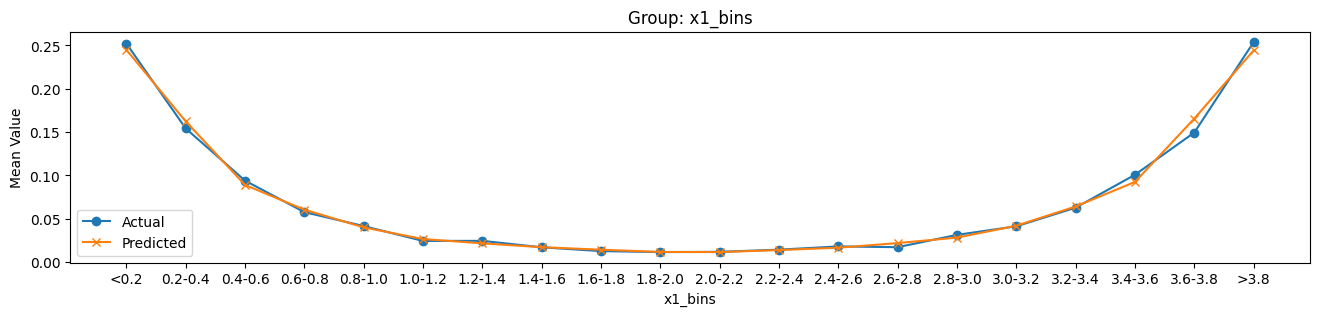

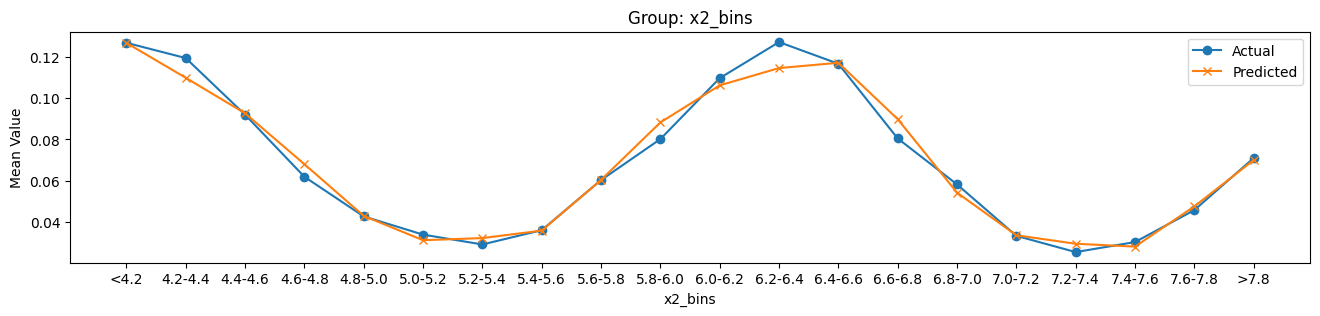

In [21]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_bcd_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_bcd_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Minimizing MSE for Classification

In [22]:
from quantbullet.linear_product_model import LinearProductRegressorBCD, LinearProductRegressorScipy

lpr_bcd = LinearProductRegressorBCD()

In [23]:
lpr_bcd.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=10 )

Iteration 1/10, Loss: 0.0565
Iteration 2/10, Loss: 0.0566
Iteration 3/10, Loss: 0.0566
Iteration 4/10, Loss: 0.0566
Iteration 5/10, Loss: 0.0566
Iteration 6/10, Loss: 0.0566
Iteration 7/10, Loss: 0.0566
Iteration 8/10, Loss: 0.0566
Iteration 9/10, Loss: 0.0566
Iteration 10/10, Loss: 0.0566


In [24]:
lpr_bcd.coef_dict

{'x1': {'x1_bias': np.float64(-21.4566563097179),
  'x1_le_0.5': np.float64(-6.130296939650548),
  'x1_0.5_1.0': np.float64(-1.4371387117218293),
  'x1_1.0_1.5': np.float64(-0.36162905838052845),
  'x1_1.5_2.0': np.float64(-0.18931489812531546),
  'x1_2.0_2.5': np.float64(0.14185441963633386),
  'x1_2.5_3.0': np.float64(0.4997935873601181),
  'x1_3.0_3.5': np.float64(1.420441542530742),
  'x1_gt_3.5': np.float64(6.066736198393392)},
 'x2': {'x2_bias': np.float64(5.863228994101355),
  'x2_le_4.5': np.float64(-1.3882343386543048),
  'x2_4.5_5.0': np.float64(-2.0065498900740404),
  'x2_5.0_5.5': np.float64(-0.11983237876416822),
  'x2_5.5_6.0': np.float64(2.126748680465983),
  'x2_6.0_6.5': np.float64(1.0383855021519073),
  'x2_6.5_7.0': np.float64(-2.933918119322009),
  'x2_7.0_7.5': np.float64(-0.4334781065473728),
  'x2_gt_7.5': np.float64(2.0816356972944465)}}

In [25]:
df['model_predict_BCD'] = lpr_bcd.predict(train_df)

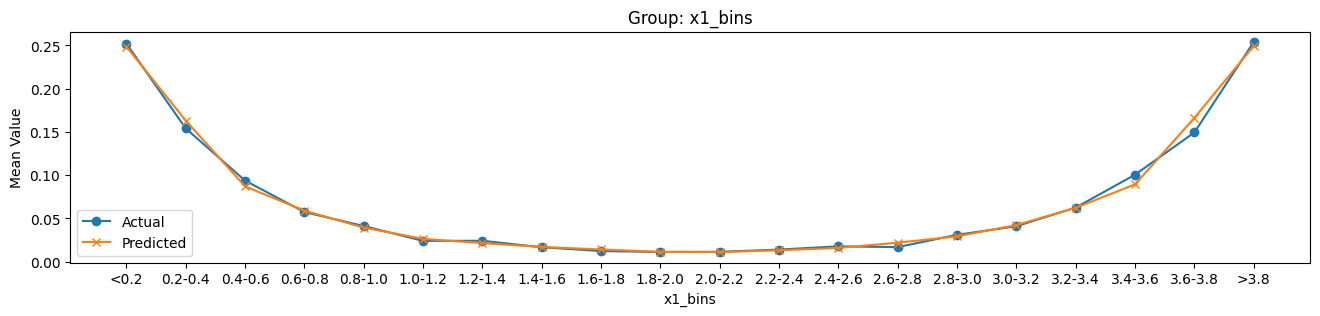

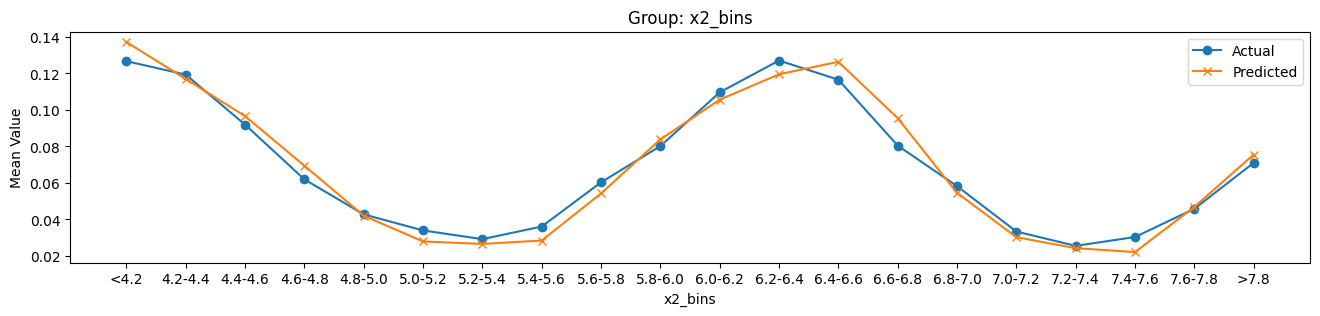

In [26]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict_BCD': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_BCD'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [27]:
lpr_scipy = LinearProductRegressorScipy( xtol=1e-12, ftol=1e-12, gtol=1e-12 )
lpr_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, verbose=2, use_jacobian=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4867e+10                                    1.44e+10    
       1              2         7.8473e+09      2.70e+10       4.20e+00       9.25e+09    
       2              4         2.1908e+09      5.66e+09       2.12e+00       6.76e+09    
       3              5         1.2206e+08      2.07e+09       2.12e+00       9.86e+08    
       4              7         7.4665e+06      1.15e+08       1.06e+00       2.94e+08    
       5              8         2.5520e+05      7.21e+06       2.12e+00       6.26e+07    
       6              9         2.8906e+04      2.26e+05       4.24e+00       2.52e+07    
       7             10         2.8344e+04      5.62e+02       8.49e+00       4.05e+07    
       8             11         3.2857e+03      2.51e+04       2.12e+00       5.27e+06    
       9             12         2.9375e+03      3.48e+02       4.24e+00       6.31e+05    

In [28]:
df['model_predict_scipy'] = lpr_scipy.predict(train_df)

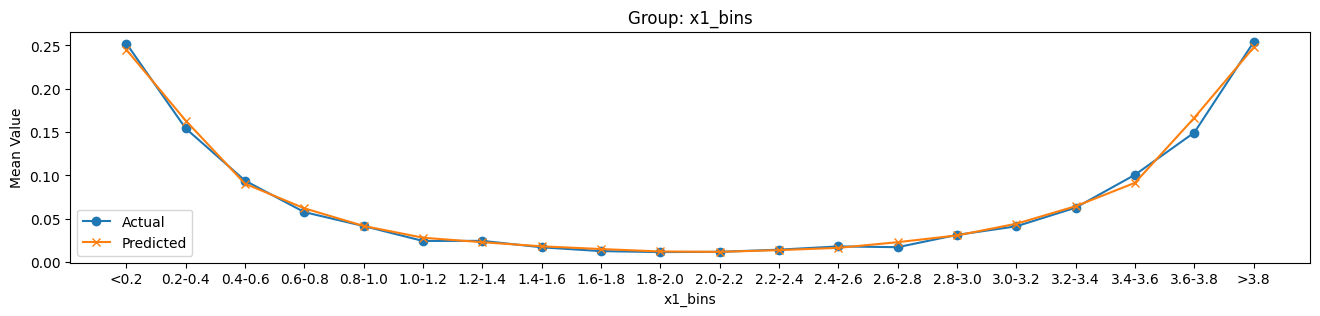

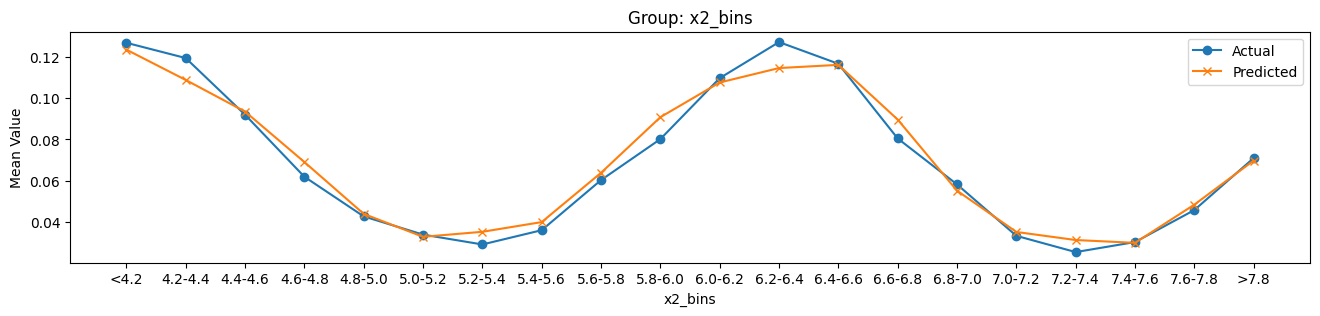

In [29]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict_scipy': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_scipy'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [30]:
# import the mse function
from sklearn.metrics import mean_squared_error
mse_bcd = mean_squared_error(df['binary_y'], df['model_predict_BCD'])
print(f'MSE (Alternating Coordinate Descent + OLS): {mse_bcd:.4f}')
mse_scipy = mean_squared_error(df['binary_y'], df['model_predict_scipy'])
print(f'MSE (Scipy Optimization): {mse_scipy:.4f}')

MSE (Alternating Coordinate Descent + OLS): 0.0565
MSE (Scipy Optimization): 0.0563
